# Earbuds Market: Bol vs CoolBlue

In this part of the project I will use the scraped data of the other programs to:
    1. Identify the key difference between product offering at Bol and CoolBlue
    2. Identify marketing strategies by the different companies by analysing review ratings.
    2. Try to predict the outcome of a review using NLP.

Let's start by importing the required libraries

In [1]:
# Analysis
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set(font='times new roman',font_scale=1,palette='Greens')

# NLP
from nltk.corpus import stopwords
stop_words=stopwords.words('dutch')
import string as string_module

# Cut warnings for now
import warnings
warnings.filterwarnings('ignore')

Below are the required functions for this script. The levenshtein_ratio_and_distance is written based on, https://en.wikipedia.org/wiki/Levenshtein_distance.

In [2]:
def simplify_string(string,remove_stops,remove_earbud_words):
    nopunc = [char for char in string if char not in string_module.punctuation]
    nopunc=''.join(nopunc) 
    nopunc=nopunc.lower()
    if remove_stops:
        stop_words=stopwords.words('dutch')
        clean_string = [word for word in nopunc.split() if word.lower() not in stop_words]
        nopunc=' '.join(clean_string)
    if remove_earbud_words:
        earbud_words='volledige volledig oordopjes draadloos draadloze sport titaniumzwart wit zwart titanium goudbeige blauw goud beige koperzwart true wireless earphones donker donkergrijs'.split()
        clean_string = [word for word in nopunc.split() if word.lower() not in earbud_words]
        nopunc=' '.join(clean_string)   
    return nopunc


def levenshtein_ratio_and_dist(string1, string2, ratio_calc = False):
    import numpy as np
    # Initialize matrix of zeros
    R = len(string1)+1
    C = len(string2)+1
    dist = np.zeros((R,C),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, R):
        for k in range(1,C):
            dist[i][0] = i
            dist[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, C):
        for row in range(1, R):
            if string1[row-1] == string2[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # Cost of deletions
                                 dist[row][col-1] + 1,          # Cost of insertions
                                 dist[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein dist Ratio
        Ratio = ((len(string1)+len(string2)) - dist[row][col]) / (len(string1)+len(string2))
        return Ratio
    else:
        return "The strings are {} edits away".format(dist[row][col])
    

    
def stars_to_rating(star,cut):
    if star<cut: # This is set as 4.0 to have # low=95 and # high 153. Choice is arbitrary
        return 'Low'
    else:
        return 'High'

Lets now get the dataframes as created by the web scraping tools:

In [3]:
EarBuds_Bol=pd.read_pickle('EarBuds_Bol.csv')
EarBuds_CoolBlue=pd.read_pickle('EarBuds_CoolBlue.csv')

In [4]:
EarBuds_Bol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Manufacturer   288 non-null    object 
 1   Name           288 non-null    object 
 2   Price [EUR]    286 non-null    float64
 3   Discount       288 non-null    object 
 4   Ret P [EUR]    286 non-null    float64
 5   Stars [x/5.0]  288 non-null    object 
 6   S_count        288 non-null    int64  
 7   Description    288 non-null    object 
 8   Pros           288 non-null    object 
 9   Cons           288 non-null    object 
 10  Reviews        288 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 24.9+ KB


In [5]:
EarBuds_CoolBlue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Manufacturer   164 non-null    object 
 1   Name           164 non-null    object 
 2   Price [EUR]    164 non-null    float64
 3   Discount       164 non-null    object 
 4   Ret P [EUR]    164 non-null    float64
 5   Stars [x/5.0]  164 non-null    object 
 6   S_count        164 non-null    int64  
 7   Description    164 non-null    object 
 8   Pros           164 non-null    object 
 9   Cons           164 non-null    object 
 10  Reviews        164 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 14.2+ KB


Nice, I managed to get the same types for every row. Further, most data cleaning has already been done during the scraping process. 

## Product offerings
Above we see that Bol offers about 284 different earbuds while coolblue only offers 164 different buds. Let's first discover the product ranges a bid. Starting with the manufacturer:

In [6]:
print('Number of manufacturers @ Bol: ',len(EarBuds_Bol['Manufacturer'].unique()))
print('Number of manufacturers @ CoolBlue: ',len(EarBuds_CoolBlue['Manufacturer'].unique()))

Number of manufacturers @ Bol:  81
Number of manufacturers @ CoolBlue:  28


It can be seen that Bol offers products from about 3 times as many manufacturers compared to CoolBlue. My hypothesis would be that prices will be lower for Bol because economies of scale. Let's find that out later.

However, the total number of product is not 3 times as larger for CoolBlue. This means that the number of products per manufacturer must be higher for CoolBlue compared to Bol. This is indeed verified below. Why this is the case can not be concluded based on this data. 

In [7]:
print('Average number of products per manufacturer @ Bol: ',len(EarBuds_Bol['Manufacturer'])/len(EarBuds_Bol['Manufacturer'].unique()))
print('Average number of products per manufacturer @ CoolBlue: ',len(EarBuds_CoolBlue['Manufacturer'])/len(EarBuds_CoolBlue['Manufacturer'].unique()))

Average number of products per manufacturer @ Bol:  3.5555555555555554
Average number of products per manufacturer @ CoolBlue:  5.857142857142857


Clearly, the offering range on Bol.com is larger. However, is this because they include more high or low end EarBuds? Let's figure that out.

Text(0.5, 1.0, 'Top 20 most frequently offered manufacturers on CoolBlue')

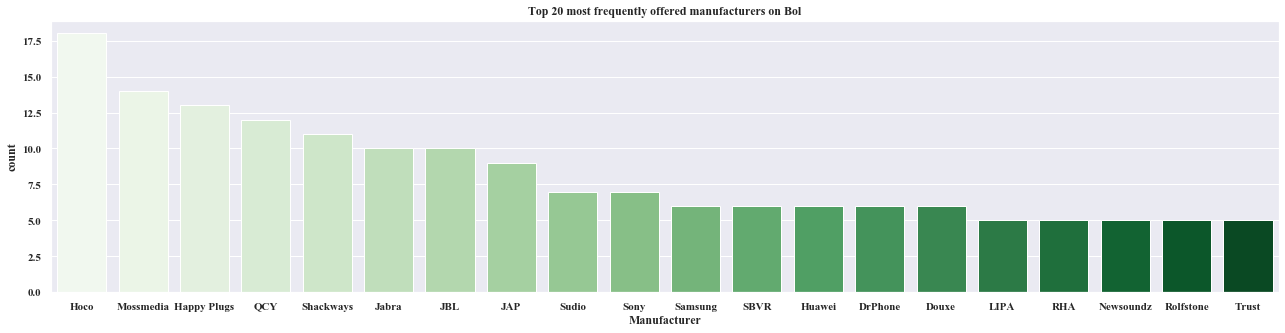

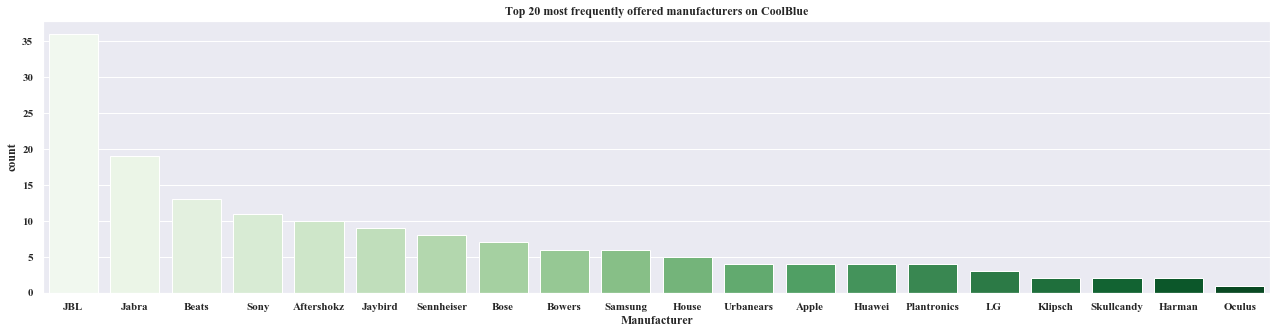

In [8]:
plt.figure(figsize=(22,5))
sns.countplot(x='Manufacturer',data=EarBuds_Bol,order=EarBuds_Bol.Manufacturer.value_counts().iloc[:20].index,palette='Greens')
plt.title('Top 20 most frequently offered manufacturers on Bol')

plt.figure(figsize=(22,5))
sns.countplot(x='Manufacturer',data=EarBuds_CoolBlue,order=EarBuds_CoolBlue.Manufacturer.value_counts().iloc[:20].index,palette='Greens')
plt.title('Top 20 most frequently offered manufacturers on CoolBlue')


It can be seen that the 'largest manufacturers' on Bol.com are low-tier manufacturers. Hoco, mossmedia, and happy plugs do in general price lower compared to top tier brands such as JBL, Jabra and Beats. CoolBlue clearly focusses on the higher customer segement compared to Bol. Can we verify this by considering average price levels per manufacturer?

In [9]:
Name_count_Bol=EarBuds_Bol.groupby('Manufacturer').count()
Name_count_Bol=Name_count_Bol['Name']

Grouped_Man_Bol = pd.concat([EarBuds_Bol.groupby('Manufacturer').mean(),Name_count_Bol], axis=1, sort=False)
Grouped_Man_Bol['Price']=Grouped_Man_Bol['Price [EUR]']
Grouped_Man_Bol=Grouped_Man_Bol.sort_values('Name',ascending=False)
print('Bol:')
Grouped_Man_Bol.head()

Bol:


,Price [EUR],Ret P [EUR],S_count,Name,Price
Manufacturer,,,,,
Hoco,47.521111,47.521111,2.611111,18,47.521111
Mossmedia,36.637143,37.494286,33.785714,14,36.637143
Happy Plugs,83.049231,86.066154,8.538462,13,83.049231
QCY,34.824167,34.824167,15.166667,12,34.824167
Shackways,28.583636,28.583636,37.545455,11,28.583636


In [10]:
Name_count_CoolBlue=EarBuds_CoolBlue.groupby('Manufacturer').count()
Name_count_CoolBlue=Name_count_CoolBlue['Name']

Grouped_Man_CoolBlue = pd.concat([EarBuds_CoolBlue.groupby('Manufacturer').mean(),Name_count_CoolBlue], axis=1, sort=False)
Grouped_Man_CoolBlue['Price']=Grouped_Man_CoolBlue['Price [EUR]']
Grouped_Man_CoolBlue=Grouped_Man_CoolBlue.sort_values('Name',ascending=False)

print('CoolBlue:')
Grouped_Man_CoolBlue.head()

CoolBlue:


,Price [EUR],Ret P [EUR],S_count,Name,Price
Manufacturer,,,,,
JBL,75.185833,75.185833,119.777778,36,75.185833
Jabra,173.412632,173.412632,105.421053,19,173.412632
Beats,208.987692,208.987692,219.384615,13,208.987692
Sony,103.803636,103.803636,31.000000,11,103.803636
Aftershokz,123.578000,131.578000,180.400000,10,123.578000


(0, 200)

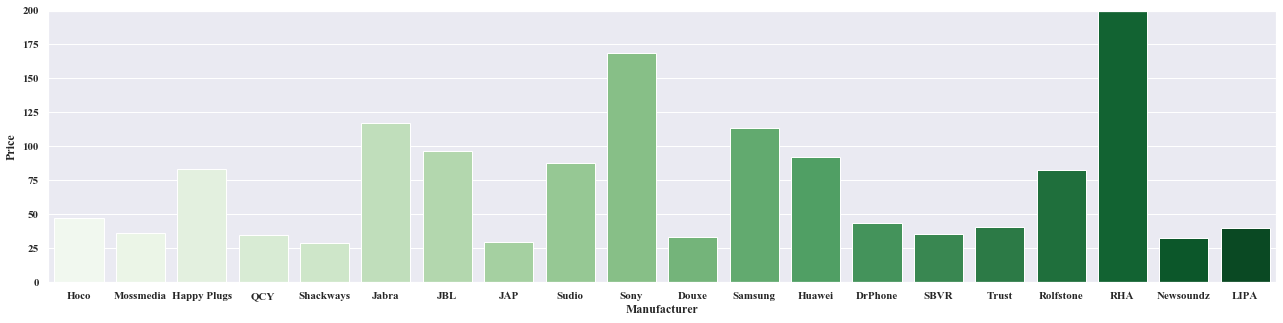

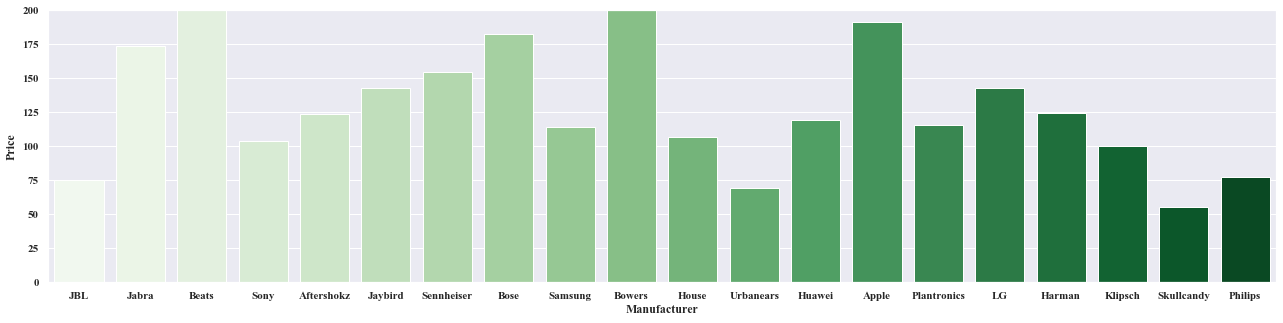

In [11]:
plt.figure(figsize=(22,5))
sns.barplot(x=Grouped_Man_Bol.index[0:20],y=Grouped_Man_Bol.Price.iloc[0:20],palette='Greens')
plt.ylim([0,200])

plt.figure(figsize=(22,5))
sns.barplot(x=Grouped_Man_CoolBlue.index[0:20],y=Grouped_Man_CoolBlue.Price.iloc[0:20],palette='Greens')
plt.ylim([0,200])

First note that the y-axis are scaled such that the graphs can be compared. This figure indeed confirms my hypothesis. 

Now, let's not compare average price but compare prices on product level. To do so, I would like to consider 5 top tier brands:
    - JBL
    - Jabra
    - Sony
    - Bose
    - Huawei
    
Let's first start by coding this for JBL afterwhich I can loop over the different brand names. I first code this for JBL for code-verification purposes. 

In [12]:
# Let's consider JBL
Manuf='JBL'

## Selection of comparison 
EarBuds_Bol_Compare = EarBuds_Bol[EarBuds_Bol['Manufacturer']==Manuf]
EarBuds_CoolBlue_Compare = EarBuds_CoolBlue[EarBuds_CoolBlue['Manufacturer']==Manuf] 

## Simplify names
EarBuds_Bol_Compare['Name']=EarBuds_Bol_Compare['Name'].map(lambda x: simplify_string(x,True,True))
EarBuds_CoolBlue_Compare['Name']=EarBuds_CoolBlue_Compare['Name'].map(lambda x: simplify_string(x,True,True))

## Remove duplicates from Bol since we are looping over Bol rows
EarBuds_Bol_Compare.drop_duplicates(subset ="Name",keep = 'first', inplace = True)

EarBuds_Bol_Compare['Name']

0             tune 220tws
1             tune 120tws
21             free inear
24     under armour flash
33            live 300tws
66     endurance peak ear
152     live 300tws inear
Name: Name, dtype: object

We now see a nice clear dataframe with clean, filtered, and unique names. Let's now search in the CoolBlue data to find a match for each Bol name. The 'correlation' between names, or one should call it similarity, is determined according the Levenshtein method, see the top of this script. This function was thoroughly verified by means of unit testing. Please contact me for further details. 

In [ ]:
Name_corr = np.zeros((len(EarBuds_Bol_Compare['Name']),len(EarBuds_CoolBlue_Compare['Name'])))  # This will be 'the correlation matrix'. Aka the matrix which contains the results of the levenshtein_ratio_and_distance 
Product_combinations=[]
for j in range(0,len(EarBuds_Bol_Compare['Name'])):
    for i in range(0,len(EarBuds_CoolBlue_Compare['Name'])):
        Name_corr[j,i]=levenshtein_ratio_and_dist(EarBuds_Bol_Compare['Name'].iloc[j],EarBuds_CoolBlue_Compare['Name'].iloc[i],True)
    CoolBlue_row=np.argmax(Name_corr[j,:])
    if np.max(Name_corr[j,:]) > 0.85:
        Price_Bol=EarBuds_Bol_Compare['Price [EUR]'].iloc[j]    
        Price_CoolBlue=EarBuds_CoolBlue_Compare['Price [EUR]'].iloc[CoolBlue_row]    
        Product_combinations.append([Manuf,EarBuds_Bol_Compare['Name'].iloc[j],Price_Bol,Price_CoolBlue])
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(pd.DataFrame(Name_corr,index=EarBuds_Bol_Compare['Name'],columns=EarBuds_CoolBlue_Compare['Name']))


That looks good. Note that I have played with the cutoff of levensthein > 0.85 to obtain this result.

Now, let's loop over the different producers.

In [ ]:
Product_combinations=[]
Product_combinations_diff=[]

Manufs='JBL Jabra Sony Bose Huawei'.split()
count=0
for Manuf in Manufs:
    ## Selection of comparison 
    EarBuds_Bol_Compare = EarBuds_Bol[EarBuds_Bol['Manufacturer']==Manuf]
    EarBuds_CoolBlue_Compare = EarBuds_CoolBlue[EarBuds_CoolBlue['Manufacturer']==Manuf] 
    
    ## Simplify names
    EarBuds_Bol_Compare['Name']=EarBuds_Bol_Compare['Name'].map(lambda x: simplify_string(x,True,True))
    EarBuds_CoolBlue_Compare['Name']=EarBuds_CoolBlue_Compare['Name'].map(lambda x: simplify_string(x,True,True))

    ## Remove duplicates from Bol since we are looping over Bol rows
    EarBuds_Bol_Compare.drop_duplicates(subset ="Name",keep = 'first', inplace = True)
    
    Name_corr = np.zeros((len(EarBuds_Bol_Compare['Name']),len(EarBuds_CoolBlue_Compare['Name'])))  # This will be 'the correlation matrix'. Aka the matrix which contains the results of the levenshtein_ratio_and_distance 

    for j in range(0,len(EarBuds_Bol_Compare['Name'])):
        for i in range(0,len(EarBuds_CoolBlue_Compare['Name'])):

            Name_corr[j,i]=levenshtein_ratio_and_dist(EarBuds_Bol_Compare['Name'].iloc[j],EarBuds_CoolBlue_Compare['Name'].iloc[i],True)
        CoolBlue_row=np.argmax(Name_corr[j,:])
        if np.max(Name_corr[j,:]) > 0.7:
            Price_Bol=EarBuds_Bol_Compare['Price [EUR]'].iloc[j]    
            Price_CoolBlue=EarBuds_CoolBlue_Compare['Price [EUR]'].iloc[CoolBlue_row]    
            Product_combinations.append([Manuf,EarBuds_Bol_Compare['Name'].iloc[j],Price_Bol,'Bol'])
            Product_combinations.append([Manuf,EarBuds_Bol_Compare['Name'].iloc[j],Price_CoolBlue,'CoolBlue'])
            Product_combinations_diff.append([Manuf,EarBuds_Bol_Compare['Name'].iloc[j],(Price_CoolBlue-Price_Bol)/Price_CoolBlue*100])
Product_combi = pd.DataFrame(Product_combinations,columns=['Manuf','Name','Price','Retailer'])
print(Product_combi.head(15))
Product_combi.drop([8,9],inplace=True)

One outlier was found, that one have been deleted. Further, this are all absolute prices. Let's also normalise these:

In [ ]:
Product_combi_diff = pd.DataFrame(Product_combinations_diff,columns=['Manuf','Name','Discount compared to CoolBlue'])
print(Product_combi_diff.head(15))
Product_combi_diff.drop([4],inplace=True)

Let's now plot both data frames on a 'per manufacturer bases' to visually observe who of the two is the cheaper.

In [ ]:
fig = plt.figure(figsize=(20,20))
ax=[0,0,0,0,0]
ax[0] = fig.add_subplot(321)
ax[1] = fig.add_subplot(323)
ax[2] = fig.add_subplot(325)
ax[3] = fig.add_subplot(222)
ax[4] = fig.add_subplot(224)
k=0
for Manuf in Manufs:
    #ax[k].set_title(Manuf)
    ax[k]=sns.barplot(x='Name', y='Price', hue='Retailer', data=Product_combi[Product_combi['Manuf']==Manuf],ax=ax[k])
    k+=1

In [ ]:
fig = plt.figure(figsize=(20,20))
ax=[0,0,0,0,0]
ax[0] = fig.add_subplot(321)
ax[1] = fig.add_subplot(323)
ax[2] = fig.add_subplot(325)
ax[3] = fig.add_subplot(222)
ax[4] = fig.add_subplot(224)
k=0
for Manuf in Manufs:
    #ax[k].set_title(Manuf)
    ax[k]=sns.barplot(x='Name', y='Discount compared to CoolBlue', data=Product_combi_diff[Product_combi_diff['Manuf']==Manuf],ax=ax[k])
    k+=1

From the above it can be concluded that Bol is significantly cheaper compared to CoolBlue. Bol.com is for the selected brands often in the order of 10% lower compared to CoolBlue.

In [ ]:
EarBuds_Bol['Discount']=EarBuds_Bol['Discount'].apply(lambda x: int(x[:-1]))
EarBuds_CoolBlue['Discount']=EarBuds_CoolBlue['Discount'].apply(lambda x: int(x[:-1]))
EarBuds_Bol.head()

In [ ]:
EarBuds_Bol_disc=EarBuds_Bol[EarBuds_Bol['Discount']>0]
EarBuds_CoolBlue_disc=EarBuds_CoolBlue[EarBuds_CoolBlue['Discount']>0]

In [ ]:
print('# of discounted items Bol: ',len(EarBuds_Bol_disc))
print('# of discounted items CoolBlue: ',len(EarBuds_CoolBlue_disc))

In [ ]:
print('Percentage discount items Bol: ',round(len(EarBuds_Bol_disc)/len(EarBuds_Bol)*100,1),'%')
print('Percentage discount items CoolBlue: ',round(len(EarBuds_CoolBlue_disc)/len(EarBuds_CoolBlue)*100,1),'%')

# NLP: Reviews
In E-commerce, descriptions are often used to boost a product. Several features should stand out in the description and that should yield a high raking. It would be benefitial to know what kind of description yields better ratings. And in particular it would be benefitial to predict the rating of a certain description. 

This code was predominantly written to apply my web-scraping and NLP skills - not to get any business related information. For now, let's apply my NLP skills on the product descriptions on Bol.com. As I said before I would like to predict from a description whether the star rating will be low of high. Let's first discover the data a bit.

## Bol.com

In [14]:
EarBuds_Bol_description = EarBuds_Bol[['Manufacturer', 'Name','Stars [x/5.0]', 'S_count', 'Description', 'Pros', 'Cons']]
EarBuds_Bol_description=EarBuds_Bol_description[EarBuds_Bol_description['Stars [x/5.0]'] != 'No stars'] # Remove the no stars ratings
EarBuds_Bol_description['Stars [x/5.0]']=EarBuds_Bol_description['Stars [x/5.0]'].apply(float) 
EarBuds_Bol_description['S_count']=EarBuds_Bol_description['S_count'].apply(int)
EarBuds_Bol_description.head()

,Manufacturer,Name,Stars [x/5.0],S_count,Description,Pros,Cons
0,JBL,Tune 220TWS - Volledig draadloze oordopjes -,4.0,164,Met de JBL TUNE 220TWS oordopjes geniet je van...,"[Batterij tot 20 uur, Hands-free bellen, Volle...",[Niet waterdicht]
1,JBL,Tune 120TWS - Zwart - Volledige draadloze,4.1,183,Maak kennis met de nieuwste (2019) volledig dr...,"[Volledig draadloos, 16 uur batterij, Bedienin...","[In-ear pasvorm is niet voor iedereen, Niet vo..."
2,Apple,Airpods Pro - met Active Noise,4.5,86,"De nieuwe oortjes van Apple, de Apple Airpods ...","[Noise cancelling en transparantie modus, Tota...",[Geen volumesensor op het oortje - wel via iPh...
3,Samsung,Galaxy Buds+ -,4.6,217,Waan jezelf bij het concert van je favoriete a...,"[Spatwaterdicht IP certificering, Het beste ge...",[Geen noise cancelling]
4,Samsung,Galaxy Buds -,4.5,386,Samsung Galaxy Buds Draadloze headset - zilver...,"[Inclusief draadloos laden-case, Gemakkelijk t...",[Draadloos laden-case niet los na te bestellen]


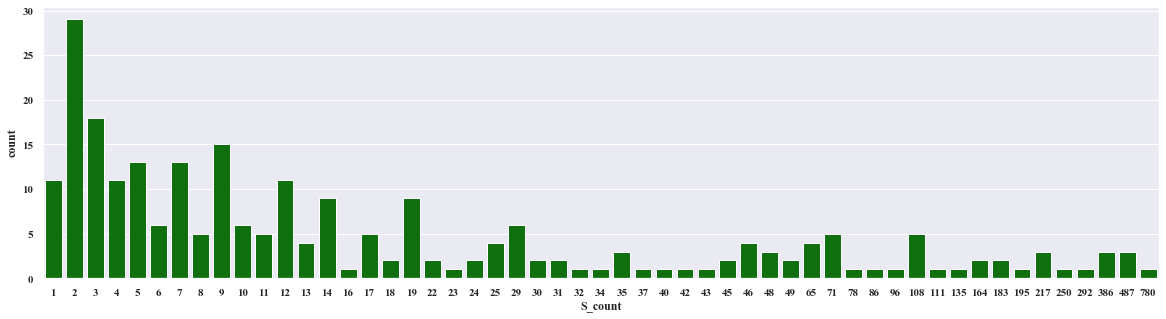

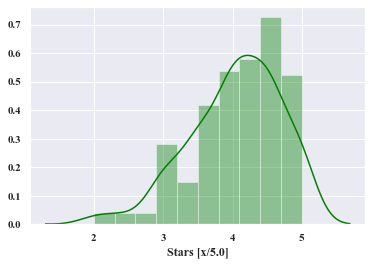

In [18]:
plt.figure(figsize=(20,5))
sns.countplot(EarBuds_Bol_description['S_count'],color='green')
plt.figure()
sns.distplot(EarBuds_Bol_description['Stars [x/5.0]'],kde=True,color='green')

It can be seen that the majority of the ratings are quite high (between the 4.0 and the 5.0 stars). I first would like to classify low and high. I make a split in the data based on the number of stars. The cut-off is set as <4.0 (low).

In [20]:
EarBuds_Bol_description['Rating']=EarBuds_Bol_description['Stars [x/5.0]'].apply(lambda x: stars_to_rating(x,4.0))
EarBuds_Bol_description['Description']=EarBuds_Bol_description['Description'].apply(lambda x: simplify_string(x,True,False))

Now, lets start by converting the simplified text (note that I deleted punctuation and dutch stop words from the description) to vector format using CountVectorise. This returns a vocabulary with size = # unique words in all descriptions:

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

VectCount = CountVectorizer()
VectCount.fit(EarBuds_Bol_description['Description'])
print('Total amount of unique words = ',len(VectCount.vocabulary_))

Total amount of unique words =  4530


The whole vocabulary is stored in the CountVectorizer VectCount. Now, lets see how this applies to the first 200 characters of the description of the first product. This is also known as the Bag-of-Words technique.

In [22]:
FirstDescr_Bol = EarBuds_Bol_description['Description'][0]
FirstDescr_Bol=FirstDescr_Bol[0:200]
FirstDescr_Bol_trans = VectCount.transform([FirstDescr_Bol])
print(FirstDescr_Bol_trans)

  (0, 70)	1
  (0, 91)	1
  (0, 453)	1
  (0, 767)	1
  (0, 973)	1
  (0, 1089)	2
  (0, 1265)	1
  (0, 1456)	1
  (0, 1563)	1
  (0, 1757)	1
  (0, 1976)	1
  (0, 2029)	1
  (0, 2058)	1
  (0, 2203)	1
  (0, 2764)	1
  (0, 2783)	2
  (0, 3842)	1
  (0, 3949)	1
  (0, 4069)	1
  (0, 4220)	1
  (0, 4253)	1
  (0, 4269)	1
  (0, 4336)	1
  (0, 4469)	1


We see that some words are present once in the description, but others 2 times. These values of course have to be scaled and normalised with respect to the full vocabulary. To this extend, I will use the tf-idf technique. Here is some background:

TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

Now, let's apply this to the vectorised text:

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

TfidfTrans_first = TfidfTransformer()
TfidfTrans_first.fit(FirstDescr_Bol_trans)
FirstDescr_Bol_trans_norm=TfidfTrans_first.transform(FirstDescr_Bol_trans)
print(FirstDescr_Bol_trans_norm)


  (0, 4469)	0.18257418583505536
  (0, 4336)	0.18257418583505536
  (0, 4269)	0.18257418583505536
  (0, 4253)	0.18257418583505536
  (0, 4220)	0.18257418583505536
  (0, 4069)	0.18257418583505536
  (0, 3949)	0.18257418583505536
  (0, 3842)	0.18257418583505536
  (0, 2783)	0.3651483716701107
  (0, 2764)	0.18257418583505536
  (0, 2203)	0.18257418583505536
  (0, 2058)	0.18257418583505536
  (0, 2029)	0.18257418583505536
  (0, 1976)	0.18257418583505536
  (0, 1757)	0.18257418583505536
  (0, 1563)	0.18257418583505536
  (0, 1456)	0.18257418583505536
  (0, 1265)	0.18257418583505536
  (0, 1089)	0.3651483716701107
  (0, 973)	0.18257418583505536
  (0, 767)	0.18257418583505536
  (0, 453)	0.18257418583505536
  (0, 91)	0.18257418583505536
  (0, 70)	0.18257418583505536


All is scaled nicely. Further, the consistency with the word count of the first part of the first message can be recognised. Now, let's apply this to the full dataset:

In [24]:
Descr_Bol_trans = VectCount.transform(EarBuds_Bol_description['Description'])
Descr_Bol_trans

<248x4530 sparse matrix of type '<class 'numpy.int64'>'
	with 32540 stored elements in Compressed Sparse Row format>

This verifies the code. The sparse matrix has size (# descriptions x # of unique words). Now let's transform that matrix using TF-IDF:

In [27]:
TfidfTrans = TfidfTransformer()
TfidfTrans.fit(Descr_Bol_trans)
Descr_Bol_trans_norm=TfidfTrans.transform(Descr_Bol_trans)
Descr_Bol_trans_norm

<248x4530 sparse matrix of type '<class 'numpy.float64'>'
	with 32540 stored elements in Compressed Sparse Row format>

Let's now split the data in two sets:

In [51]:
from sklearn.model_selection import train_test_split

descr_train, descr_test, star_train, star_test = train_test_split(Descr_Bol_trans_norm, EarBuds_Bol_description['Rating'], test_size=0.3,random_state=42)

Since we have two 'classes' (low and high). I want to apply,
    - Logistic Regression
    - Support Vector Machines
    - Naive Bayes
and see what's best for this application. Let's start with the LR and save the scores:

In [52]:
from sklearn.linear_model import LogisticRegression
logRes = LogisticRegression()
logRes.fit(descr_train, star_train)
star_pred=logRes.predict(descr_test)

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

precisions=[]
recalls=[]
fscores=[]
precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)


print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.77      0.96      0.85        46
         Low       0.89      0.55      0.68        29

    accuracy                           0.80        75
   macro avg       0.83      0.75      0.77        75
weighted avg       0.82      0.80      0.79        75



The models performs well for precision and recall for High, but the recall for Low lacks. One reason for this is that the number of Low training points is much less compared to the High values. Let's now see how the rest performs:

In [53]:
pred_models=['LogRes','SVM','NaiveBayes']

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

descr_train, descr_test, star_train, star_test = train_test_split(EarBuds_Bol_description['Description'], EarBuds_Bol_description['Rating'], test_size=0.3,random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ SVM classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.86      0.96      0.91        46
         Low       0.92      0.76      0.83        29

    accuracy                           0.88        75
   macro avg       0.89      0.86      0.87        75
weighted avg       0.88      0.88      0.88        75



In [54]:
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

describ_star_results_Bol=pd.DataFrame(np.vstack((precisions,recalls,fscores)),index=['Precision','Recall','Fscore'],columns=pred_models)

              precision    recall  f1-score   support

        High       0.76      0.96      0.85        46
         Low       0.88      0.52      0.65        29

    accuracy                           0.79        75
   macro avg       0.82      0.74      0.75        75
weighted avg       0.81      0.79      0.77        75



From the above we clearly see that SVM performs best on all values. Let's visualise this a bit:

In [55]:
describ_star_results_Bol=describ_star_results_Bol.transpose()
describ_star_results_Bol=describ_star_results_Bol.reset_index()
describ_star_results_Bol.columns=['Models', 'Precision', 'Recall', 'Fscore']
describ_star_results_Bol


,Models,Precision,Recall,Fscore
0,LogRes,0.817154,0.800000,0.787275
1,SVM,0.883595,0.880000,0.877432
2,NaiveBayes,0.806464,0.786667,0.771148


Text(0, 0.5, 'Value')

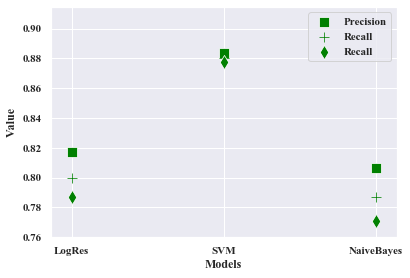

In [57]:
fig=plt.figure()
axes=fig.add_axes([0.1,0.1,0.8,0.8])
sns.scatterplot(x='Models', y='Precision',data=describ_star_results_Bol,color='green',label='Precision',s=100, marker="s")
sns.scatterplot(x='Models', y='Recall',data=describ_star_results_Bol,color='green',label='Recall',s=100, marker="+")
sns.scatterplot(x='Models', y='Fscore',data=describ_star_results_Bol,color='green',label='Recall',s=100, marker="d")

axes.set_ylabel('Value')

This verifies what was seen in the classification reports. SVM performs really well and I can indeed predict the ratings from a given description!

## CoolBlue

Let's do the same for coolblue. First, let's clean and transform the data a bit:

In [61]:
EarBuds_CoolBlue_description = EarBuds_CoolBlue[['Manufacturer', 'Name','Stars [x/5.0]', 'S_count', 'Description', 'Pros', 'Cons']]
EarBuds_CoolBlue_description=EarBuds_CoolBlue_description[EarBuds_CoolBlue_description['Stars [x/5.0]'] != 'No review']
EarBuds_CoolBlue_description['Stars [x/5.0]']=EarBuds_CoolBlue_description['Stars [x/5.0]'].apply(float)
EarBuds_CoolBlue_description['S_count']=EarBuds_CoolBlue_description['S_count'].apply(int)

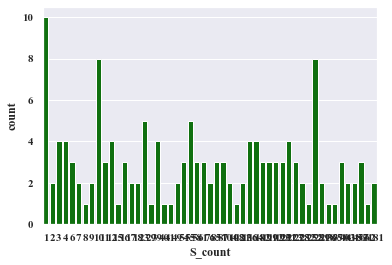

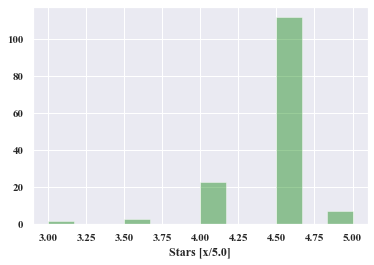

In [64]:
plt.figure()
sns.countplot(EarBuds_CoolBlue_description['S_count'],color='green')
plt.figure()
sns.distplot(EarBuds_CoolBlue_description['Stars [x/5.0]'],color='green',kde=False)

We see that CoolBlue almost always rates it's products 4.5. We barely see any Low ratings. This is because CoolBlue positions itself in the high segement of the market. I guess this will eventually yield some difficulties in the predictions since we do barely have Low training points and therefore the boundary is super vague. Let's see what happens.

In [66]:
EarBuds_CoolBlue_description['Rating']=EarBuds_CoolBlue_description['Stars [x/5.0]'].apply(lambda x: stars_to_rating(x,4.1)) # This is set as 4.0 to have # low=28 and # high 119. Choice is arbitrary 
EarBuds_CoolBlue_description['Description']=EarBuds_CoolBlue_description['Description'].apply(lambda x: simplify_string(x,True,False))
EarBuds_CoolBlue_description.head()

,Manufacturer,Name,Stars [x/5.0],S_count,Description,Pros,Cons,Rating
0,Apple,AirPods Pro met Draadloze Oplaadcase,4.5,662,apple airpods pro jouw favoriete deuntjes onde...,[Actieve noise cancelling dempt storende omgev...,"[Je hebt een Apple iPhone, iPad of Mac nodig o...",High
1,Apple,AirPods 2 met oplaadcase,4.5,3181,let meegeleverde oplaadcase laad alleen bedraad,[Dankzij de H1 chip verbind je de oordopjes au...,"[Je hebt een Apple iPhone, iPad of Mac nodig o...",High
2,Beats,Powerbeats Pro Zwart,4.5,252,haal beste jezelf boven tijdens sporten powerb...,[Door het volledig draadloze ontwerp heb je ge...,[De draagwijze is minder geschikt voor brildra...,High
3,Jabra,Elite 75t Titanium Zwart,4.5,193,jabra elite 75t last kabels tijdens luisteren ...,[De Jabra Elite 75t is 20% kleiner dan zijn vo...,[Er worden geen schuimoordoppen meegeleverd.],High
4,Apple,AirPods 2 met draadloze oplaadcase,4.5,3181,apple airpods 2 wireless charging case gedoe s...,[Dankzij de H1 chip verbind je de oordopjes au...,"[Je hebt een Apple iPhone, iPad of Mac nodig o...",High


What can be seen above is that the description is simplified now. Further, the stars are floats iso strings now.

Let's apply the three models again:

In [72]:
descr_train, descr_test, star_train, star_test = train_test_split(EarBuds_CoolBlue_description['Description'], EarBuds_CoolBlue_description['Rating'], test_size=0.3,random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ LogRes classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precisions=[]
recalls=[]
fscores=[]
precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.76      1.00      0.86        34
         Low       0.00      0.00      0.00        11

    accuracy                           0.76        45
   macro avg       0.38      0.50      0.43        45
weighted avg       0.57      0.76      0.65        45



In [73]:
descr_train, descr_test, star_train, star_test = train_test_split(EarBuds_CoolBlue_description['Description'], EarBuds_CoolBlue_description['Rating'], test_size=0.3,random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ SVM classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.89      1.00      0.94        34
         Low       1.00      0.64      0.78        11

    accuracy                           0.91        45
   macro avg       0.95      0.82      0.86        45
weighted avg       0.92      0.91      0.90        45



In [74]:
descr_train, descr_test, star_train, star_test = train_test_split(EarBuds_CoolBlue_description['Description'], EarBuds_CoolBlue_description['Rating'], test_size=0.3,random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ NB classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.76      1.00      0.86        34
         Low       0.00      0.00      0.00        11

    accuracy                           0.76        45
   macro avg       0.38      0.50      0.43        45
weighted avg       0.57      0.76      0.65        45



I am not going to plot these because we see that both logRes and NB have problems predicting the low values. This is because the majority of the rating is 4.5. Very few are 2-3 stars and therefore the algorithms were not properly trained.

# Review classification

Now let's make things interesting. In the previous I considered the descriptions written by the websites themselves - they appear to be quite predictable however for some cases there was not enough data to actually train the algos. For individual reviews however, there is a lot more train data but the consistency might be much lower of course. 

Before we start, let's first create a data frame which consists of all the reviews from both website with a column for the review and a column for the star:

In [85]:
# Initialise lists
Names_list=[]
Review_list=[]
Star_list=[]

Earbuds_Bol_review = EarBuds_Bol[['Name','Reviews']]
Earbuds_CoolBlue_review = EarBuds_CoolBlue[['Name','Reviews']]

# Read all bol data into the different lists
for i in range(0,len(Earbuds_Bol_review)):
    for j in range(0,len(Earbuds_Bol_review['Reviews'].iloc[i])):
        review=Earbuds_Bol_review['Reviews'].iloc[i][j]
        review_split=review.split(',')
        text=review_split[0]
        if len(review_split)>1: # Sometimes commas are used in the review so we have to merge these
            text=' '.join(review_split[:-1])
        Review_list.append(text)
        Star_list.append(float(review_split[-1]))
        Names_list.append(Earbuds_Bol_review['Name'].iloc[i])

# Read all coolblue data into the different lists
for i in range(0,len(Earbuds_CoolBlue_review)):
    for j in range(0,len(Earbuds_CoolBlue_review['Reviews'].iloc[i])):
        review=Earbuds_CoolBlue_review['Reviews'].iloc[i][j]
        review_split=review.split(',')
        text=review_split[0]
        if len(review_split)>1:
            text=' '.join(review_split[:-1])
        Review_list.append(text)
        if round(float(review_split[-1])/2,1)<1.0:
            Star_list.append(1.0)
        else:
            Star_list.append(round(float(review_split[-1])/2,1))
        Names_list.append(Earbuds_Bol_review['Name'].iloc[i])
len(Names_list)

3084

The total number of data points is now about 3,000. This is at least 10 times as much compared to the description data. Let's create a dataframe from these:

In [87]:
Review_data = pd.DataFrame(np.vstack((Star_list,Review_list,Names_list)).transpose(),columns=['Stars','Review','Name'])
Review_data['Stars']=Review_data['Stars'].apply(float)
Review_data['Rating']=Review_data['Stars'].apply(lambda x:stars_to_rating(x,3.5))
Review_data=Review_data.reindex(columns='Stars Rating Review Name'.split())
Review_data.head()

,Stars,Rating,Review,Name
0,5.0,High,Volgende dag in huis door bol.com! Makkelijk t...,Tune 220TWS - Volledig draadloze oordopjes -
1,4.0,High,Deze oortjes heb ik nu ongeveer twee weken in ...,Tune 220TWS - Volledig draadloze oordopjes -
2,5.0,High,Ze zijn ligt en zitten prettig in het oor. Voo...,Tune 220TWS - Volledig draadloze oordopjes -
3,4.0,High,Allereerst voelen de oortjes goed en stevig aa...,Tune 220TWS - Volledig draadloze oordopjes -
4,5.0,High,Lang gezocht naar een niet-Apple product.Deze ...,Tune 220TWS - Volledig draadloze oordopjes -


This is exactly what I need. Let's see how have are classified Low and High based on a cut-off of 3.5:

In [91]:
Review_data['Rating'].value_counts()

High    2483
Low      601
Name: Rating, dtype: int64

So about 20\% is classied low. This number is much higher compared to the previos example.

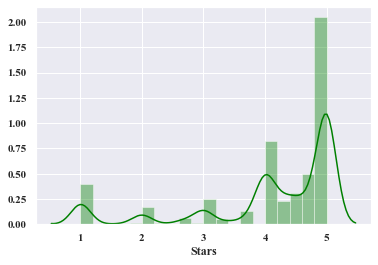

In [92]:
plt.close('all')
sns.distplot(Review_data['Stars'],kde=True,color='green',bins=20)

We do see some peak around the integers, which of course is a human biase. Further, larger peaks are observed at the extreme values. This is in line with what is often seen for reviews.

Let's split this data and run some analyses.

In [282]:
descr_train, descr_test, star_train, star_test = train_test_split(Review_data['Review'], Review_data['Rating'], test_size=0.3,random_state=42)


In [283]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ LogRes classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precisions=[]
recalls=[]
fscores=[]
precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.81      0.99      0.89       737
         Low       0.74      0.09      0.16       189

    accuracy                           0.81       926
   macro avg       0.77      0.54      0.53       926
weighted avg       0.80      0.81      0.74       926



In [284]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ LogRes classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.86      0.97      0.91       737
         Low       0.78      0.39      0.52       189

    accuracy                           0.85       926
   macro avg       0.82      0.68      0.72       926
weighted avg       0.84      0.85      0.83       926



In [96]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LogRes classifier
])

pipeline.fit(descr_train,star_train)
star_pred = pipeline.predict(descr_test)

precision,recall,fscore,support=score(star_test,star_pred,average='weighted')
precisions.append(precision)
recalls.append(recall)
fscores.append(fscore)

print(classification_report(star_test, star_pred))

              precision    recall  f1-score   support

        High       0.76      1.00      0.86        34
         Low       0.00      0.00      0.00        11

    accuracy                           0.76        45
   macro avg       0.38      0.50      0.43        45
weighted avg       0.57      0.76      0.65        45



Again, it can be seen that SVM is by far outperforming the others. The final score is somewhat lower compared to the description predictions but this is quite logical since people are less consistent than the creators of a website.